# FNO Model Testing

This notebook loads a trained FNO model and compares predictions with ground truth.

In [1]:
import torch
from operator_data_pipeline import get_nfv_dataset, preprocess_grids, GridDataset
from torch.utils.data import DataLoader
from numerical_methods.plotter import plot_grid_density

# Device selection: cuda > mps > cpu
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

/Users/mchami/ETH/Thesis/saint-venant/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


3it [00:00, 17.02it/s]                       


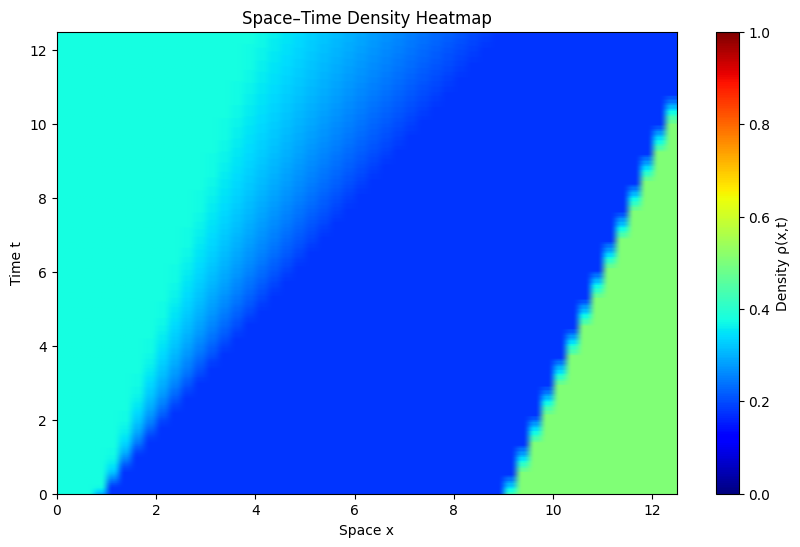

In [2]:
# Grid parameters
from operator_learning.operator_data_pipeline import GridMaskInner


nx = 50
nt = 250
dx = 0.25
dt = 0.05
max_steps = 3
n_samples = 10

# Generate dataset
grids = get_nfv_dataset(n_samples, nx, nt, dx, dt, max_steps)
dataset = GridDataset(preprocess_grids(grids, nx, nt, dx, dt), transform=[GridMaskInner()], cleaner=None)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

# Preview a sample grid
plot_grid_density(grids[0], nx, nt, dx, dt)

In [3]:
from model import OperatorModel
from neuralop.models import FNO

# Model configuration - should match training configuration
model = OperatorModel(FNO,
    n_modes=(64, 16),
    hidden_channels=64,
    in_channels=3,
    out_channels=1,
    n_layers=4
)

# Load trained weights
model_path = 'fno.pth'  # Update this path to your trained model
state_dict = torch.load(model_path, weights_only=False, map_location=device)
state_dict = {k: v for k, v in state_dict.items() if k != '_metadata'}
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

print(f"Model loaded from {model_path}")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Model loaded from fno.pth


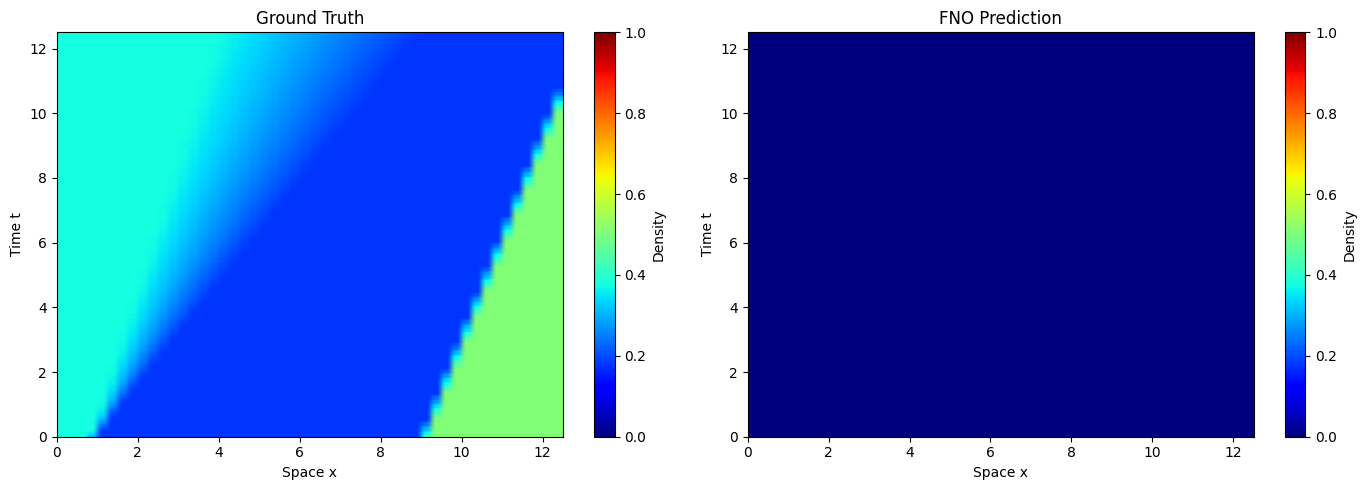

In [4]:
import matplotlib.pyplot as plt

# Get a batch of data
for input_grid, target in dataloader:
    break

# Move data to device
input_grid = input_grid.to(device)
target = target.to(device)

# Run model prediction
with torch.no_grad():
    pred = model(input_grid)

# Select sample index to visualize
idx = 0

# Plot target and prediction side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Target
ax = axes[0]
im = ax.imshow(target[idx].squeeze().cpu().numpy(), aspect='auto', origin='lower',
               extent=[0, nx * dx, 0, nt * dt], cmap='jet', vmin=0, vmax=1)
ax.set_xlabel('Space x')
ax.set_ylabel('Time t')
ax.set_title('Ground Truth')
plt.colorbar(im, ax=ax, label='Density')

# Prediction
ax = axes[1]
im = ax.imshow(pred[idx].squeeze().cpu().numpy(), aspect='auto', origin='lower',
               extent=[0, nx * dx, 0, nt * dt], cmap='jet', vmin=0, vmax=1)
ax.set_xlabel('Space x')
ax.set_ylabel('Time t')
ax.set_title('FNO Prediction')
plt.colorbar(im, ax=ax, label='Density')

plt.tight_layout()
plt.show()

In [5]:
pred[0, 0, 200]

tensor([-1.9528, -1.8113, -1.8580, -1.7924, -1.7433, -1.7059, -1.7587, -1.8309,
        -1.8721, -1.8796, -1.8651, -1.8430, -1.8299, -1.8727, -1.9644, -2.0734,
        -2.1837, -2.2775, -2.3146, -2.3353, -2.3511, -2.3651, -2.3896, -2.4176,
        -2.4448, -2.4945, -2.5183, -2.5223, -2.5171, -2.4910, -2.4538, -2.4336,
        -2.4562, -2.4925, -2.5111, -2.4963, -2.4978, -2.5001, -2.4963, -2.4560,
        -2.4013, -2.3125, -2.2113, -2.1789, -2.1966, -2.1055, -2.0617, -2.1543,
        -1.9959, -1.9319], device='mps:0')

MSE: 6.268775
MAE: 2.480874


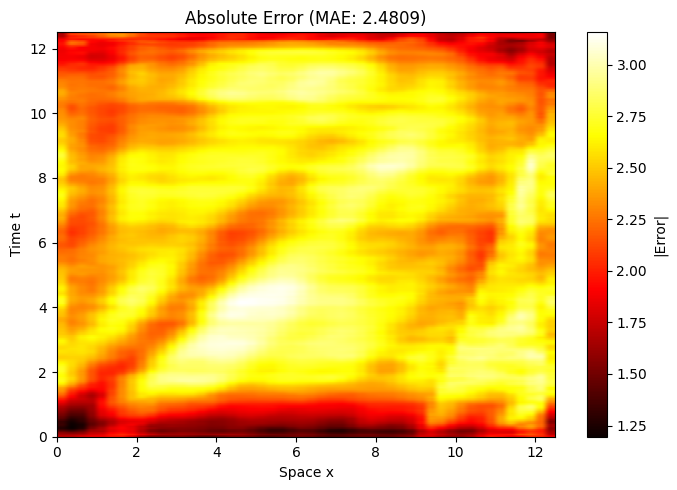

In [6]:
# Compute and display error
error = (pred[idx] - target[idx]).abs()
mse = ((pred[idx] - target[idx]) ** 2).mean().item()
mae = error.mean().item()

print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")

# Plot error map
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(error.squeeze().cpu().numpy(), aspect='auto', origin='lower',
               extent=[0, nx * dx, 0, nt * dt], cmap='hot')
ax.set_xlabel('Space x')
ax.set_ylabel('Time t')
ax.set_title(f'Absolute Error (MAE: {mae:.4f})')
plt.colorbar(im, ax=ax, label='|Error|')
plt.tight_layout()
plt.show()